In [1]:
from ema_workbench import save_results, ema_logging
from ema_workbench.util.utilities import load_results
import numpy as np
import pandas as pd
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from dike_model_function import DikeNetwork  # @UnresolvedImport
from ema_workbench import (Model, RealParameter, ScalarOutcome, 
                           MultiprocessingEvaluator, SequentialEvaluator, ema_logging,
                           Scenario, Policy)

from ema_workbench.em_framework.evaluators import BaseEvaluator

from ema_workbench.em_framework.optimization import (HyperVolume,
                                                     EpsilonProgress)
 

from problem_formulation import get_model_for_problem_formulation

from ema_workbench.analysis import parcoords, prim

dike_model, planning_steps = get_model_for_problem_formulation(7)

In [3]:
experiments, outcomes = load_results("results_analysis2.tar.gz")

[MainProcess/INFO] results loaded succesfully from C:\Users\archipel-03\Documents\GitHub\MBDM\final assignment\results_analysis2.tar.gz


In [4]:
experiments

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,EWS_DaysToThreat,scenario,policy,model
0,12.0,196.049289,10.0,0.928707,261.436603,10.0,0.556528,101.881912,1.5,0.219548,...,6.0,9.0,10.0,1.0,3.0,4.0,2.0,0,0,dikesnet
1,107.0,88.962604,1.5,0.873807,267.855008,1.5,0.911126,53.258601,1.0,0.009783,...,6.0,9.0,10.0,1.0,3.0,4.0,2.0,1,0,dikesnet
2,44.0,118.839013,1.5,0.200569,208.688641,10.0,0.222467,66.918365,1.0,0.209988,...,6.0,9.0,10.0,1.0,3.0,4.0,2.0,2,0,dikesnet
3,32.0,332.225929,10.0,0.369382,348.458264,1.0,0.487069,140.640012,1.5,0.072263,...,6.0,9.0,10.0,1.0,3.0,4.0,2.0,3,0,dikesnet
4,63.0,287.600177,1.5,0.728108,298.352511,1.5,0.254642,60.607872,10.0,0.543411,...,6.0,9.0,10.0,1.0,3.0,4.0,2.0,4,0,dikesnet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,63.0,212.613048,1.5,0.448640,204.004672,1.5,0.174004,310.417081,1.5,0.700947,...,9.0,7.0,3.0,7.0,1.0,10.0,4.0,495,99,dikesnet
49996,68.0,319.486358,1.5,0.926600,53.324749,10.0,0.715006,94.511333,10.0,0.621755,...,9.0,7.0,3.0,7.0,1.0,10.0,4.0,496,99,dikesnet
49997,82.0,295.493397,1.0,0.942111,85.325680,1.0,0.420585,81.426887,1.5,0.426154,...,9.0,7.0,3.0,7.0,1.0,10.0,4.0,497,99,dikesnet
49998,18.0,114.435242,1.0,0.348111,83.316255,1.5,0.764033,248.393443,10.0,0.478631,...,9.0,7.0,3.0,7.0,1.0,10.0,4.0,498,99,dikesnet


## Search for scenarios where outcomes are very high

In [5]:
x = experiments.drop([o.name for o in dike_model.levers], axis=1)
y = (outcomes['A.3_Expected Number of Deaths'] > 0.1) & (outcomes['Expected Evacuation Costs'] > 20000)

In [6]:
data = pd.DataFrame.from_dict(outcomes)[y]
data

,A.1_Expected Annual Damage,A.1_Dike Investment Costs,A.1_Expected Number of Deaths,A.2_Expected Annual Damage,A.2_Dike Investment Costs,A.2_Expected Number of Deaths,A.3_Expected Annual Damage,A.3_Dike Investment Costs,A.3_Expected Number of Deaths,A.4_Expected Annual Damage,A.4_Dike Investment Costs,A.4_Expected Number of Deaths,A.5_Expected Annual Damage,A.5_Dike Investment Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
337,0.0,2.621674e+08,0.0,0.000000e+00,2.659851e+08,0.000000,4.431170e+08,9.510277e+07,0.132729,0.000000,6.852597e+07,0.000000,0.000000e+00,9.460430e+07,0.000000,1.081800e+09,22564.967562
1501,0.0,1.814208e+08,0.0,1.988514e+06,1.848301e+08,0.000179,8.881531e+08,1.023477e+08,0.132021,0.000000,8.453408e+06,0.000000,0.000000e+00,9.413158e+07,0.000000,9.821000e+08,39075.987278
1524,0.0,1.814208e+08,0.0,1.837194e+08,1.848301e+08,0.014557,8.768141e+08,1.023477e+08,0.129356,0.000000,8.453408e+06,0.000000,0.000000e+00,9.413158e+07,0.000000,9.821000e+08,47891.788548
1530,0.0,1.814208e+08,0.0,2.632374e+08,1.848301e+08,0.032372,5.228280e+08,1.023477e+08,0.123320,0.000000,8.453408e+06,0.000000,0.000000e+00,9.413158e+07,0.000000,9.821000e+08,60175.039068
1571,0.0,1.814208e+08,0.0,6.685881e+06,1.848301e+08,0.000765,6.212224e+08,1.023477e+08,0.119862,933542.555291,8.453408e+06,0.000063,0.000000e+00,9.413158e+07,0.000000,9.821000e+08,35659.852406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48876,0.0,1.977520e+08,0.0,0.000000e+00,2.067731e+08,0.000000,9.345875e+08,9.601945e+07,0.142006,0.000000,2.826544e+07,0.000000,1.247708e+08,7.090316e+07,0.010477,1.334800e+09,41587.781854
48882,0.0,1.977520e+08,0.0,0.000000e+00,2.067731e+08,0.000000,9.547904e+08,9.601945e+07,0.144005,0.000000,2.826544e+07,0.000000,7.648131e+07,7.090316e+07,0.006415,1.334800e+09,38941.664646
48896,0.0,1.977520e+08,0.0,1.221064e+06,2.067731e+08,0.000179,4.711874e+08,9.601945e+07,0.114773,0.000000,2.826544e+07,0.000000,2.795080e+08,7.090316e+07,0.032930,1.334800e+09,51768.729954
48927,0.0,1.977520e+08,0.0,0.000000e+00,2.067731e+08,0.000000,7.217343e+08,9.601945e+07,0.143581,0.000000,2.826544e+07,0.000000,0.000000e+00,7.090316e+07,0.000000,1.334800e+09,35068.427301


In [7]:
x.dtypes

A.0_ID flood wave shape     float64
A.1_Bmax                    float64
A.1_Brate                  category
A.1_pfail                   float64
A.2_Bmax                    float64
A.2_Brate                  category
A.2_pfail                   float64
A.3_Bmax                    float64
A.3_Brate                  category
A.3_pfail                   float64
A.4_Bmax                    float64
A.4_Brate                  category
A.4_pfail                   float64
A.5_Bmax                    float64
A.5_Brate                  category
A.5_pfail                   float64
discount rate 0            category
discount rate 1            category
discount rate 2            category
scenario                   category
policy                     category
model                      category
dtype: object

In [8]:
x_numeric = x.select_dtypes(exclude=pd.CategoricalDtype)
x_categorical = x.select_dtypes(include=pd.CategoricalDtype)

rotated_experiments, rotation_matrix = prim.pca_preprocess(x_numeric, y)

In [9]:
rotated_x = pd.concat([rotated_experiments, x_categorical], axis=1)
rotated_x = rotated_x.drop(columns=['policy'])

[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 50000 points remaining, containing 466 cases of interest
[MainProcess/INFO] mean: 0.23, mass: 0.012, coverage: 0.296137339055794, density: 0.23 restricted_dimensions: 5


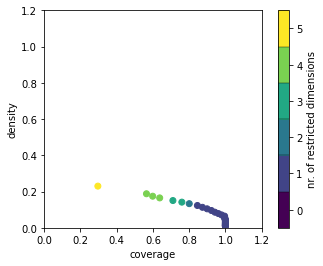

In [10]:
from ema_workbench.analysis.prim_util import PRIMObjectiveFunctions


prim_alg = prim.Prim(rotated_x, y, threshold=0.1, peel_alpha=0.1, mass_min=0.01)
box = prim_alg.find_box()

box.show_tradeoff()
plt.show()

In [11]:
box.inspect()

coverage    0.296137
density         0.23
id                32
mass           0.012
mean            0.23
res_dim            5
Name: 32, dtype: object

                          box 32                   \
                             min              max   
r_10                    -1.71541         -1.61075   
r_5                     -2.68452          1.59052   
r_7                     -3.05592         0.834941   
A.1_Brate            {10.0, 1.0}      {10.0, 1.0}   
discount rate 0  {1.5, 2.5, 3.5}  {1.5, 2.5, 3.5}   

                                                 
                                      qp values  
r_10             [-1.0, 1.854296896574163e-130]  
r_5                 [-1.0, 0.12512018663838512]  
r_7                  [-1.0, 0.5158636164577108]  
A.1_Brate           [0.00562845258168534, -1.0]  
discount rate 0      [0.5158636164577108, -1.0]  



[MainProcess/INFO] 50000 points remaining, containing 466 cases of interest
[MainProcess/INFO] mean: 0.1423076923076923, mass: 0.052, coverage: 0.7939914163090128, density: 0.1423076923076923 restricted_dimensions: 9


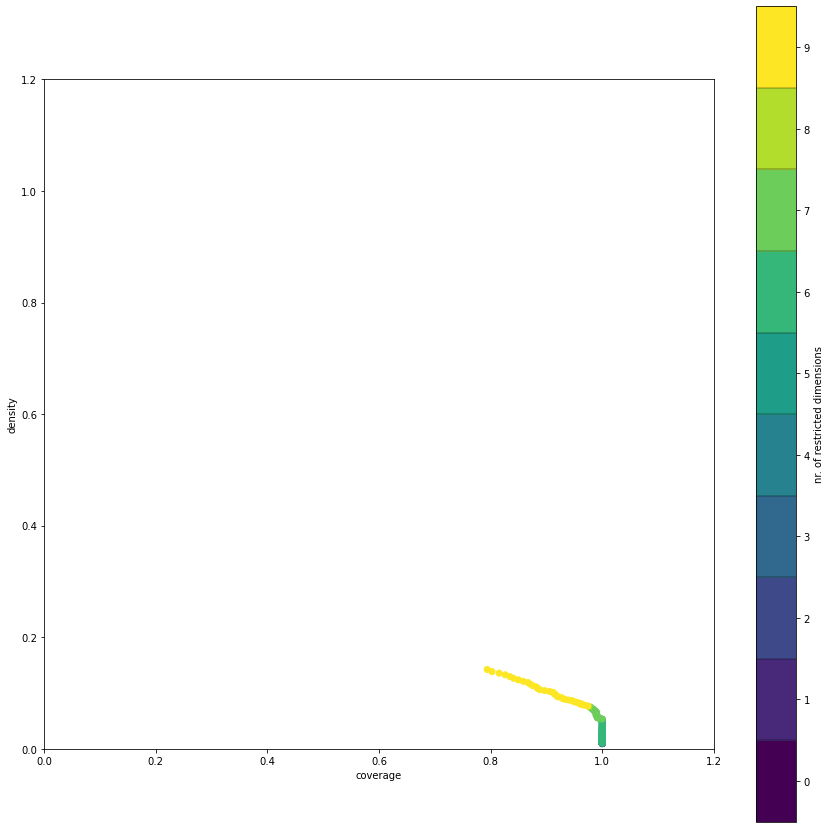

In [12]:
x1 = experiments.drop([o.name for o in dike_model.levers] + ["policy", "model"], axis=1)

prim_alg = prim.Prim(x1, y, threshold=0.1, peel_alpha=0.01)
box1 = prim_alg.find_box()



box1.show_tradeoff()

fig = plt.gcf()
fig.set_size_inches(15,15)
plt.show()

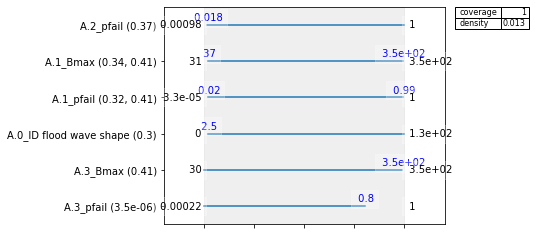

In [13]:
box1.inspect(30, style='graph')
plt.show()

In [14]:
data = data.loc[:, ['A.3_Expected Annual Damage', 'A.3_Dike Investment Costs', 'A.3_Expected Number of Deaths',
                       'RfR Total Costs', 'Expected Evacuation Costs']]
print(data.idxmin())

A.3_Expected Annual Damage       33538
A.3_Dike Investment Costs        49337
A.3_Expected Number of Deaths     1728
RfR Total Costs                  45001
Expected Evacuation Costs        27741
dtype: int64


In [15]:
selected = experiments.loc[list(data.idxmin()), [o.name for o in dike_model.uncertainties]]
selected

,discount rate 0,discount rate 1,discount rate 2,A.0_ID flood wave shape,A.1_Bmax,A.1_pfail,A.1_Brate,A.2_Bmax,A.2_pfail,A.2_Brate,A.3_Bmax,A.3_pfail,A.3_Brate,A.4_Bmax,A.4_pfail,A.4_Brate,A.5_Bmax,A.5_pfail,A.5_Brate
33538,1.5,2.5,1.5,105.0,289.673898,0.252120,1.0,37.572001,0.043859,1.0,184.112884,0.182677,1.5,275.928873,0.941298,1.5,255.299501,0.302480,10.0
49337,3.5,4.5,2.5,128.0,308.736358,0.737029,1.0,52.049469,0.334905,1.0,207.742493,0.000215,10.0,215.583602,0.375577,10.0,325.136384,0.458190,1.5
1728,3.5,1.5,1.5,125.0,305.224813,0.499130,1.0,192.814775,0.577857,1.5,67.665053,0.027261,1.0,126.596620,0.932791,1.5,306.175812,0.528827,1.5
45001,1.5,3.5,1.5,107.0,88.962604,0.873807,1.5,267.855008,0.911126,1.5,53.258601,0.009783,1.0,273.400712,0.895547,10.0,322.614656,0.413758,10.0
27741,2.5,1.5,2.5,84.0,298.466937,0.041096,1.5,272.040316,0.754632,1.0,268.652847,0.012257,10.0,217.229410,0.912129,1.5,345.781226,0.047905,1.0


In [16]:
scenarios = [Scenario(f"{index}", **row) for index, row in selected.iterrows()]

In [17]:
convergence_metrics = [EpsilonProgress()]
nfe= 150000
epsilons = [0.1,]*len(dike_model.outcomes)

In [18]:
%%time
with MultiprocessingEvaluator(dike_model) as evaluator:
    results_test, convergence_test = evaluator.optimize(nfe=nfe, searchover='levers', convergence=convergence_metrics, reference=scenarios[0],
                                     epsilons=epsilons)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/150000 nfe
[MainProcess/INFO] generation 5: 499/150000 nfe
[MainProcess/INFO] generation 10: 998/150000 nfe
[MainProcess/INFO] generation 15: 1496/150000 nfe
[MainProcess/INFO] generation 20: 1993/150000 nfe
[MainProcess/INFO] generation 25: 2493/150000 nfe
[MainProcess/INFO] generation 30: 2993/150000 nfe
[MainProcess/INFO] generation 35: 3493/150000 nfe
[MainProcess/INFO] generation 40: 3988/150000 nfe
[MainProcess/INFO] generation 45: 4488/150000 nfe
[MainProcess/INFO] generation 50: 4987/150000 nfe
[MainProcess/INFO] generation 55: 5483/150000 nfe
[MainProcess/INFO] generation 60: 5981/150000 nfe
[MainProcess/INFO] generation 65: 6479/150000 nfe
[MainProcess/INFO] generation 70: 6979/150000 nfe
[MainProcess/INFO] generation 75: 7478/150000 nfe
[MainProcess/INFO] generation 80: 7975/150000 nfe
[MainProcess/INFO] generation 85: 8473/150000 nfe
[MainProcess/INFO] generation 90: 8969/150000 nfe
[MainProcess/INFO] genera

Wall time: 21h 25min 8s


In [19]:
results_test.to_csv("results/results_test.csv")
convergence_test.to_csv("results/convergence_test.csv")

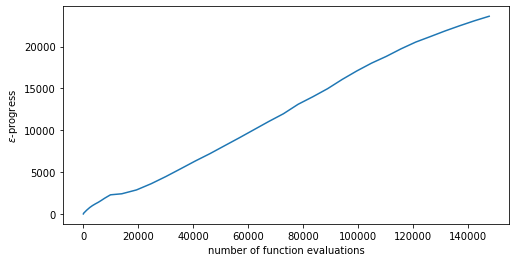

In [20]:
fig, ax1  = plt.subplots(ncols=1, sharex=True, figsize=(8,4))
ax1.plot(convergence_test.nfe, convergence_test.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
#ax2.plot(convergence.nfe, convergence.hypervolume)

ax1.set_xlabel('number of function evaluations')

plt.show()

# Part two (Needs to be reconsidered)

In [3]:
experiments, outcomes = load_results("mordm_14.tar.gz")

[MainProcess/INFO] results loaded succesfully from C:\Users\archipel-03\Documents\GitHub\MBDM\final assignment\mordm_14.tar.gz


In [4]:
y = (outcomes['A.3_Expected Number of Deaths'] > 0.01) & (outcomes['Expected Evacuation Costs'] > 500)

In [5]:
from ema_workbench.analysis import parcoords

# Scenarios where policies fail
data = pd.DataFrame({k:v[y] for k,v in outcomes.items()})
data = data.loc[:, ['A.3_Expected Annual Damage', 'A.3_Dike Investment Costs', 'A.3_Expected Number of Deaths',
                       'RfR Total Costs', 'Expected Evacuation Costs']]

all_data = pd.DataFrame({k:v for k,v in outcomes.items()})
all_data = all_data.loc[:, ['A.3_Expected Annual Damage', 'A.3_Dike Investment Costs', 'A.3_Expected Number of Deaths',
                       'RfR Total Costs', 'Expected Evacuation Costs']]


# Plot parcoords

# limits = parcoords.get_limits(all_data)
# axes = parcoords.ParallelAxes(limits)
# axes.plot(all_data, color='lightgrey')
# axes.plot(data, color='blue')
# plt.show()

# best case, worst case

In [6]:
print(data.idxmax())
print(data.idxmin())

A.3_Expected Annual Damage       2080
A.3_Dike Investment Costs         208
A.3_Expected Number of Deaths    1817
RfR Total Costs                   211
Expected Evacuation Costs        2228
dtype: int64
A.3_Expected Annual Damage       1858
A.3_Dike Investment Costs        2795
A.3_Expected Number of Deaths     210
RfR Total Costs                   667
Expected Evacuation Costs        1875
dtype: int64


From model answers assingment 9:

"we now have 8 indices, so we could optimize for each of these 8 scenarios. This might be a bit overkil, so you could also take a worst case stance. In that case,  you would use the max for max_P and the minimum for the others."

We have 10, if 8 is considered overkill, then 10 is as well of course -> only look at worst case scenarios

In [7]:
# also all we need are the uncertainty columns
selected = experiments.loc[[2080, 208, 1817, 211, 2228], [o.name for o in dike_model.uncertainties]]
selected

,discount rate 0,discount rate 1,discount rate 2,A.0_ID flood wave shape,A.1_Bmax,A.1_pfail,A.1_Brate,A.2_Bmax,A.2_pfail,A.2_Brate,A.3_Bmax,A.3_pfail,A.3_Brate,A.4_Bmax,A.4_pfail,A.4_Brate,A.5_Bmax,A.5_pfail,A.5_Brate
2080,1.5,4.5,4.5,35.0,342.172256,0.707574,1.0,281.200769,0.359614,1.0,213.332428,0.061301,1.5,267.833242,0.977158,1.0,48.258163,0.703787,10.0
208,1.5,4.5,3.5,9.0,86.111998,0.283894,1.0,186.022805,0.719144,10.0,348.139286,0.192826,1.0,292.240994,0.459393,1.0,49.249269,0.225115,1.0
1817,2.5,3.5,3.5,104.0,73.722050,0.906667,1.0,145.228068,0.930921,10.0,123.740329,0.089158,1.0,313.607411,0.089385,1.5,85.047309,0.251847,1.5
211,2.5,2.5,1.5,94.0,180.527983,0.100533,10.0,204.129345,0.284163,1.0,336.903089,0.046943,1.5,229.364253,0.660123,1.5,104.006830,0.662753,1.5
2228,2.5,4.5,1.5,107.0,157.251415,0.185296,1.0,216.479790,0.780965,1.5,66.713489,0.173686,10.0,170.719763,0.382678,1.0,348.004001,0.571851,1.5


In [8]:
selected.iloc[0,:].to_dict()

{'discount rate 0': 1.5,
 'discount rate 1': 4.5,
 'discount rate 2': 4.5,
 'A.0_ID flood wave shape': 35.0,
 'A.1_Bmax': 342.1722562523505,
 'A.1_pfail': 0.7075741690985592,
 'A.1_Brate': 1.0,
 'A.2_Bmax': 281.2007686556127,
 'A.2_pfail': 0.35961447363204485,
 'A.2_Brate': 1.0,
 'A.3_Bmax': 213.33242843485885,
 'A.3_pfail': 0.061300965794355865,
 'A.3_Brate': 1.5,
 'A.4_Bmax': 267.8332415871045,
 'A.4_pfail': 0.9771579776926737,
 'A.4_Brate': 1.0,
 'A.5_Bmax': 48.25816317222797,
 'A.5_pfail': 0.7037870798480067,
 'A.5_Brate': 10.0}

In [9]:
scenarios = [Scenario(f"{index}", **row) for index, row in selected.iterrows()]

Assignment 7 on hypervolume:

Sometimes it is known a priori. For example in the lake problem, reliability is scalled between 0 and 1. In contrast, the bounds on max_P are not known up front. To help with this, we can introduce a constraint saying that max_P must be below a particulare threshold.

In [10]:
convergence_metrics = [HyperVolume.from_outcomes(dike_model.outcomes)] 
nfe= 1000
epsilons = [0.1,]*len(dike_model.outcomes)

ValueError: no expected_range is set for ['A.1_Expected Annual Damage 0', 'A.2_Expected Annual Damage 0', 'A.4_Expected Annual Damage 0', 'A.5_Expected Annual Damage 0', 'A.1_Expected Annual Damage 1', 'A.2_Expected Annual Damage 1', 'A.4_Expected Annual Damage 1', 'A.5_Expected Annual Damage 1', 'A.1_Expected Annual Damage 2', 'A.2_Expected Annual Damage 2', 'A.4_Expected Annual Damage 2', 'A.5_Expected Annual Damage 2']

In [27]:
%%time
with MultiprocessingEvaluator(dike_model) as evaluator:
    results_test, convergence_test = evaluator.optimize(nfe=nfe, searchover='levers', convergence=convergence_metrics, reference=scenarios[1],
                                     epsilons=epsilons)

[MainProcess/INFO] generation 0: 0/1000 nfe


KeyboardInterrupt: 

In [37]:
results_1.to_csv("results/results_1.csv")
convergence_1.to_csv("results/convergence_1.csv")

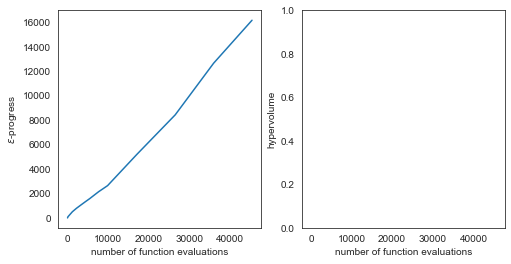

In [35]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence_1.nfe, convergence_1.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
#ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

In [15]:
%%time

results_1_file = "results/results_1.csv"
convergence_1_file = "results/convergence_1.csv"

try:
    # Only run the experiments again if data hasn't been generated yet
    results_1 = pd.read_csv("results/results_1.csv")
    convergence_1 = pd.read_csv("results/convergence_1.csv")
except IOError:
    with SequentialEvaluator(dike_model) as evaluator:
        results_1, convergence_1 = evaluator.optimize(nfe=nfe, searchover='levers', convergence=convergence_metrics, reference=scenarios[1],
                                 epsilons=epsilons)
          
    results_1.to_csv("results/results_1.csv")
    convergence_1.to_csv("results/convergence_1.csv")

[MainProcess/INFO] generation 0: 0/1000 nfe


KeyboardInterrupt: 

In [ ]:
def optimize(scenario, nfe, model, converge_metrics, epsilons):


    with MultiprocessingEvaluator(model) as evaluator:
        results, convergence = evaluator.optimize(nfe=nfe, searchover='levers',
                                     convergence=convergence_metrics,
                                     epsilons=epsilons,
                                     reference=scenario)
    return results, convergence

results = []
for scenario in scenarios:
    convergence_metrics = [HyperVolume.from_outcomes(dike_model.outcomes),
                           EpsilonProgress()]
    epsilons = [0.1,]*len(dike_model.outcomes)
    
    results.append(optimize(scenario, 1000, dike_model, convergence_metrics, epsilons))

[MainProcess/INFO] generation 0: 0/1000 nfe


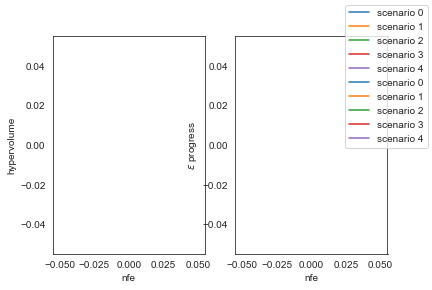

In [90]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
for i, (_, convergence) in enumerate(results):
    ax1.plot(convergence.nfe, convergence.hypervolume, label=f'scenario {i}')
    ax2.plot(convergence.nfe, convergence.epsilon_progress, label=f'scenario {i}')

ax1.set_ylabel('hypervolume')
ax1.set_xlabel('nfe')
ax2.set_ylabel('$\epsilon$ progress')
ax2.set_xlabel('nfe')
fig.legend()
plt.show()

# Part 3

## Re-evaluate under deep uncertainty

Combine the pareto set of solutions found for each scenario. Next, turn each solution into a policy object. If you have a very large number of policies, you can choose to down sample your policies in some reasoned way (*e.g.*, picking min and max on each objective, slicing across the pareto front with a particular step size). As a rule of thumb, try to limit the set of policies to at most 50. 

Re-evaluate the combined set of solutions over 1000 scenarios sampled using LHS.

In [21]:
for i, (result, _) in enumerate(results):
    result = result.iloc[:,:]

In [24]:
result.loc[:,[o.name for o in dike_model.levers]]

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
0,0,1,0,1,0,1,0,1,1,1,...,4,1,7,1,5,2,9,6,3,10
1,1,1,0,0,0,0,0,0,1,1,...,10,4,5,2,9,5,9,0,2,8
2,1,1,1,1,0,0,1,0,0,1,...,10,10,10,8,1,8,6,3,1,3
3,0,0,1,0,0,1,1,1,0,1,...,4,6,0,0,5,5,0,9,5,10
4,1,1,1,0,1,1,1,0,0,1,...,7,9,8,0,1,4,5,1,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,0,1,0,1,1,0,0,1,1,1,...,6,6,9,0,4,5,4,7,0,5
79,0,1,0,1,1,0,0,0,0,0,...,5,1,10,9,9,3,10,1,9,9
80,1,0,0,1,1,0,1,1,0,0,...,3,2,4,0,3,5,0,3,6,6
81,1,1,1,1,0,1,0,1,0,1,...,2,9,2,1,5,2,8,4,8,4


In [25]:
policies = []
for i, (result, _) in enumerate(results):
    result = result.loc[:,[o.name for o in dike_model.levers]]
    for j, row in result.iterrows():
        policy = Policy(f'scenario {i} option {j}', **row.to_dict())
        policies.append(policy)

In [27]:
policies[0:10]

[Policy({'0_RfR 0': 0, '0_RfR 1': 1, '0_RfR 2': 1, '1_RfR 0': 1, '1_RfR 1': 1, '1_RfR 2': 0, '2_RfR 0': 1, '2_RfR 1': 0, '2_RfR 2': 0, '3_RfR 0': 0, '3_RfR 1': 0, '3_RfR 2': 0, '4_RfR 0': 0, '4_RfR 1': 0, '4_RfR 2': 1, 'EWS_DaysToThreat': 0, 'A.1_DikeIncrease 0': 7, 'A.1_DikeIncrease 1': 8, 'A.1_DikeIncrease 2': 10, 'A.2_DikeIncrease 0': 9, 'A.2_DikeIncrease 1': 7, 'A.2_DikeIncrease 2': 8, 'A.3_DikeIncrease 0': 1, 'A.3_DikeIncrease 1': 0, 'A.3_DikeIncrease 2': 1, 'A.4_DikeIncrease 0': 6, 'A.4_DikeIncrease 1': 3, 'A.4_DikeIncrease 2': 4, 'A.5_DikeIncrease 0': 1, 'A.5_DikeIncrease 1': 7, 'A.5_DikeIncrease 2': 0}),
 Policy({'0_RfR 0': 1, '0_RfR 1': 0, '0_RfR 2': 1, '1_RfR 0': 1, '1_RfR 1': 1, '1_RfR 2': 1, '2_RfR 0': 0, '2_RfR 1': 1, '2_RfR 2': 1, '3_RfR 0': 0, '3_RfR 1': 1, '3_RfR 2': 1, '4_RfR 0': 0, '4_RfR 1': 0, '4_RfR 2': 1, 'EWS_DaysToThreat': 2, 'A.1_DikeIncrease 0': 6, 'A.1_DikeIncrease 1': 3, 'A.1_DikeIncrease 2': 5, 'A.2_DikeIncrease 0': 2, 'A.2_DikeIncrease 1': 10, 'A.2_DikeInc

In [50]:
n_scenarios = 1000

In [29]:
with MultiprocessingEvaluator(dike_model) as evaluator:
    reeevaluation_results = evaluator.perform_experiments(n_scenarios, policies=policies[0:10])

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 10 scenarios * 10 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 10 cases completed
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 50 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 70 cases completed
[MainProcess/INFO] 80 cases completed
[MainProcess/INFO] 90 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


### Domain Criterion

In [ ]:
thresholds = {'A.1_Expected Number of Deaths' : 0.01, 'A.2_Expected Number of Deaths' : 0.01, 'A.3_Expected Number of Deaths' : 0.01,
              'A.4_Expected Number of Deaths' : 0.01, 'A.5_Expected Number of Deaths' : 0.01, 'A.3_Dike Investment Costs' : 1e8, 
              "RfR Total Costs" : 1e8}

In [48]:
outcomes_df = pd.DataFrame.from_dict(outcomes)
outcomes_df

,A.1_Expected Annual Damage,A.1_Dike Investment Costs,A.1_Expected Number of Deaths,A.2_Expected Annual Damage,A.2_Dike Investment Costs,A.2_Expected Number of Deaths,A.3_Expected Annual Damage,A.3_Dike Investment Costs,A.3_Expected Number of Deaths,A.4_Expected Annual Damage,A.4_Dike Investment Costs,A.4_Expected Number of Deaths,A.5_Expected Annual Damage,A.5_Dike Investment Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
0,0.0,3.221037e+08,0.0,0.000000e+00,3.283336e+08,0.000000,8.800418e+08,4.129222e+07,1.359014,0.000000e+00,3.604660e+07,0.000000,1.527666e+07,7.074086e+07,0.010490,8.916000e+08,0.0
1,0.0,3.221037e+08,0.0,0.000000e+00,3.283336e+08,0.000000,1.024391e+08,4.129222e+07,0.180448,1.300055e+06,3.604660e+07,0.000508,1.009112e+07,7.074086e+07,0.006928,8.916000e+08,0.0
2,0.0,3.221037e+08,0.0,0.000000e+00,3.283336e+08,0.000000,2.072457e+07,4.129222e+07,0.041257,0.000000e+00,3.604660e+07,0.000000,2.539863e+07,7.074086e+07,0.028671,8.916000e+08,0.0
3,0.0,3.221037e+08,0.0,0.000000e+00,3.283336e+08,0.000000,2.308219e+08,4.129222e+07,0.586640,0.000000e+00,3.604660e+07,0.000000,0.000000e+00,7.074086e+07,0.000000,8.916000e+08,0.0
4,0.0,3.221037e+08,0.0,0.000000e+00,3.283336e+08,0.000000,3.413713e+06,4.129222e+07,0.004685,0.000000e+00,3.604660e+07,0.000000,1.703720e+08,7.074086e+07,0.114495,8.916000e+08,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,1.689989e+08,0.0,9.355763e+07,1.806918e+08,0.078631,0.000000e+00,9.782557e+07,0.000000,0.000000e+00,5.365900e+07,0.000000,0.000000e+00,1.229712e+08,0.000000,1.170600e+09,0.0
96,0.0,1.689989e+08,0.0,0.000000e+00,1.806918e+08,0.000000,0.000000e+00,9.782557e+07,0.000000,0.000000e+00,5.365900e+07,0.000000,7.415962e+07,1.229712e+08,0.085073,1.170600e+09,0.0
97,0.0,1.689989e+08,0.0,4.491567e+06,1.806918e+08,0.005248,7.414816e+06,9.782557e+07,0.016076,0.000000e+00,5.365900e+07,0.000000,0.000000e+00,1.229712e+08,0.000000,1.170600e+09,0.0
98,0.0,1.689989e+08,0.0,3.713628e+06,1.806918e+08,0.005335,0.000000e+00,9.782557e+07,0.000000,0.000000e+00,5.365900e+07,0.000000,0.000000e+00,1.229712e+08,0.000000,1.170600e+09,0.0


In [54]:
experiments, outcomes = reeevaluation_results

thresholds = {'A.1_Expected Number of Deaths' : 0.01, 'A.2_Expected Number of Deaths' : 0.01, 'A.3_Expected Number of Deaths' : 0.01,
              'A.4_Expected Number of Deaths' : 0.01, 'A.5_Expected Number of Deaths' : 0.01, 'A.3_Dike Investment Costs' : 1e8, 
              "RfR Total Costs" : 1e8}

overall_scores = {}
for policy in experiments.policy.unique():
    logical = experiments.policy == policy
    scores = {}
    for k, v in outcomes.items():
        try:
            n = np.sum(v[logical]<=thresholds[k])
        except KeyError:
            continue
        scores[k] = n/n_scenarios 
    overall_scores[policy] = scores
        
overall_scores = pd.DataFrame(overall_scores).T

In [55]:
overall_scores

,A.1_Expected Number of Deaths,A.2_Expected Number of Deaths,A.3_Dike Investment Costs,A.3_Expected Number of Deaths,A.4_Expected Number of Deaths,A.5_Expected Number of Deaths,RfR Total Costs
scenario 0 option 0,1.0,1.0,1.0,0.3,1.0,0.4,0.0
scenario 0 option 1,1.0,1.0,0.0,1.0,1.0,1.0,0.0
scenario 0 option 2,1.0,1.0,1.0,1.0,1.0,1.0,0.0
scenario 0 option 3,1.0,1.0,1.0,0.9,1.0,0.9,0.0
scenario 0 option 4,1.0,1.0,1.0,0.6,0.8,1.0,0.0
scenario 0 option 5,1.0,0.8,0.0,1.0,1.0,1.0,0.0
scenario 0 option 6,1.0,1.0,1.0,0.9,1.0,0.8,0.0
scenario 0 option 7,1.0,0.6,0.0,1.0,0.9,0.9,0.0
scenario 0 option 8,1.0,1.0,1.0,1.0,1.0,0.9,0.0
scenario 0 option 9,1.0,0.7,1.0,0.6,1.0,0.9,0.0


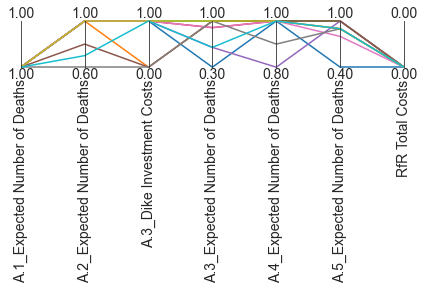

In [56]:
limits = parcoords.get_limits(overall_scores)
paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(overall_scores)
plt.show()

### Max Regret

In [58]:
def calculate_regret(data, best):
    return np.abs(best-data)

In [64]:
overall_regret = {}
max_regret = {}
for outcome in dike_model.outcomes:
    policy_column = experiments['policy']
    
    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes[outcome.name], 
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})
    
    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')
    
    # flatten the resulting hierarchical index resulting from 
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)
    
    # we need to control the broadcasting. 
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across 
    # the row and the actual values in the row
    #
    outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
    
    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()

    max_regret = pd.DataFrame(max_regret)

<ipython-input-64-f44384ddd3dc>:27: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()


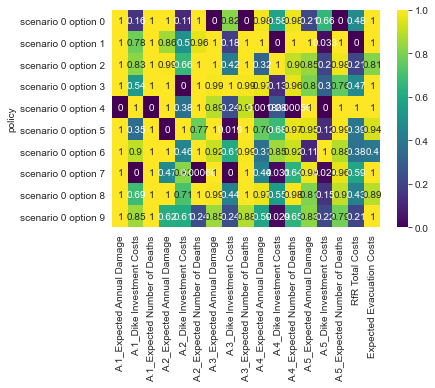

In [65]:
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.show()

C:\Users\archipel-03\anaconda3\lib\site-packages\ema_workbench\analysis\parcoords.py:198: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)
C:\Users\archipel-03\anaconda3\lib\site-packages\ema_workbench\analysis\parcoords.py:261: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


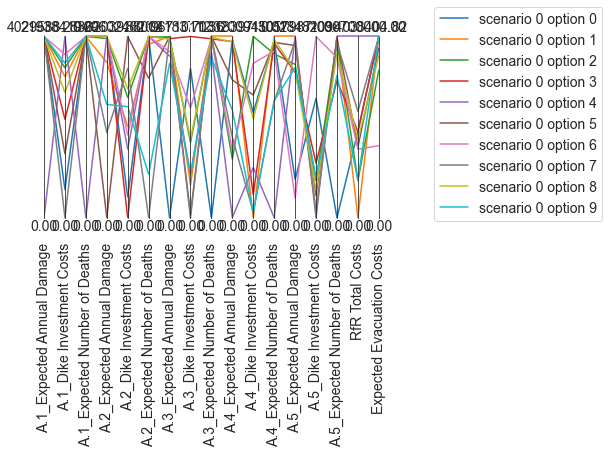

In [67]:
colors = sns.color_palette()

data = max_regret

# makes it easier to identify the policy associated with each line
# in the parcoords plot
# data['policy'] = data.index.astype("float64")

limits = parcoords.get_limits(data)
limits.loc[0, [o.name for o in dike_model.outcomes]] = 0

paraxes = parcoords.ParallelAxes(limits)
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()
    
plt.show()

From model answers assignment 8:

Note that we have been looking at the maximum regret. I also saved the distribution of regret over the set of scenarios. So let's visualize this and see what we can learn from it

In [69]:
from collections import defaultdict

policy_regret = defaultdict(dict)
for key, value in overall_regret.items():
    for policy in value:
        policy_regret[policy][key] = value[policy]

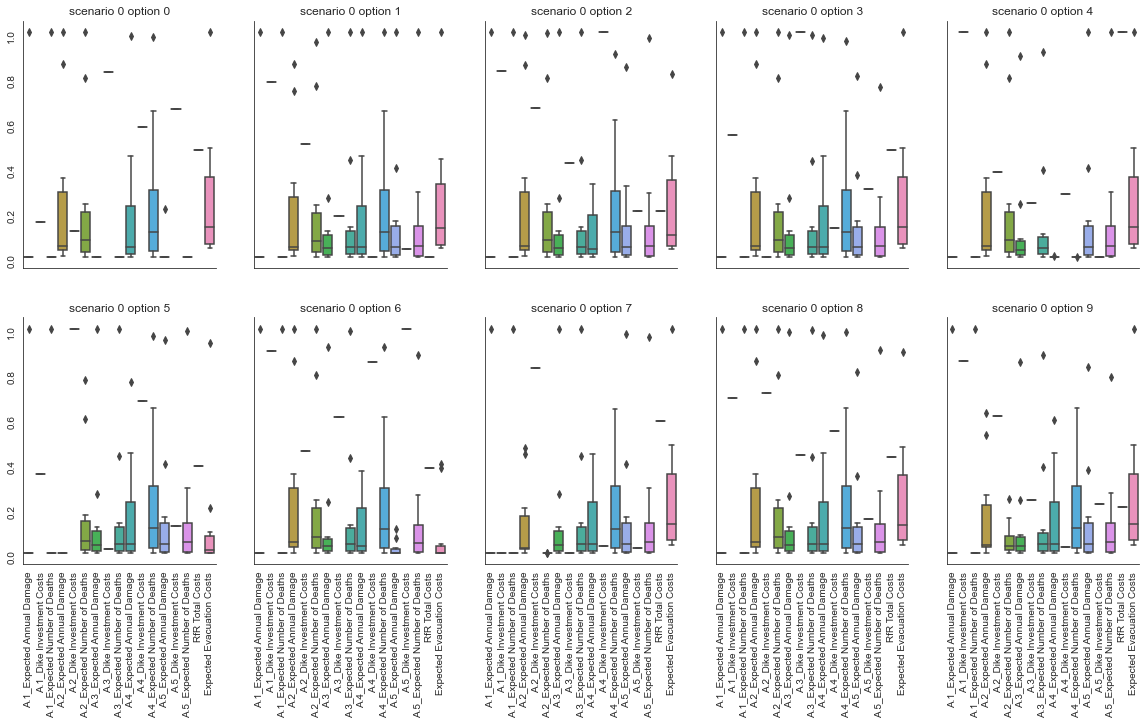

In [79]:
# this generates a 2 by 2 axes grid, with a shared X and Y axis
# accross all plots
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(20,10), 
                         sharey=True, sharex=True)

# to ensure easy iteration over the axes grid, we turn it
# into a list. Because there are ten plots, I hard coded
# this. 
axes = [axes[0,0], axes[0,1], axes[0,2], axes[0,3], axes[0,4],
        axes[1,0], axes[1,1], axes[1,2], axes[1,3], axes[1,4]]

# zip allows us to zip together the list of axes and the list of 
# key value pairs return by items. If we iterate over this
# it returns a tuple of length 2. The first item is the ax
# the second items is the key value pair.
for ax, (policy, regret) in zip(axes, policy_regret.items()):
    data = pd.DataFrame(regret)

    # we need to scale the regret to ensure fair visual
    # comparison. We can do that by divding by the maximum regret
    data = data/max_regret.max(axis=0)
    sns.boxplot(data=data, ax=ax)
    
    ax.tick_params(labelrotation=90)
    #plt.xticks(rotation=90)
    
    # removes top and left hand black outline of axes
    sns.despine()
    
    # ensure we know which policy the figure is for
    ax.set_title(str(policy))
    


plt.show()